In [1]:
from qutip import *

from scipy.optimize import curve_fit as cf

import numpy as np
from numpy import pi as pi
from numpy import sqrt as sqrt

import matplotlib.pyplot as plt
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14}

plt.rc('font', **font)

In [2]:
def Rs(t,p):
    t = t/180*np.pi
    p = p/180*np.pi
    return np.array([np.sin(t)*np.cos(p), np.sin(t)*np.sin(p), np.cos(t)])    

def Rx(tx):
    tx = tx/180*np.pi
    Rx = np.array([[1,0,0],
                   [0,np.cos(tx),-np.sin(tx)],
                   [0,np.sin(tx), np.cos(tx)]])
    return Rx

def Rz(tz):
    tz= tz/180*np.pi
    Rz = np.array([[np.cos(tz), -np.sin(tz), 0],
                   [np.sin(tz), np.cos(tz), 0],
                   [0, 0, 1]])    
    return Rz

def Eigenbasis_Expansion(H):
    Q = np.zeros(H.shape, dtype=np.complex)
    for i, ev in enumerate(H.eigenstates()[1]):    
        Q[:,i] = ev.full().flatten()    
    return Q

In [3]:
def boltzmann(E, T):
    h = 6.626e-34
    kB = 1.38e-23
    return np.exp(-h*E/(kB*T))

def coth(gs, T):
    h = 6.626e-34
    kB = 1.38e-23
    return np.tanh(h*gs*1e9/(2*kB*T))**(-1)

def lorentzian(nu, nu0, Gamma, A, c):
    return A*(Gamma/2)**2/((nu-nu0)**2+(Gamma/2)**2) + c 

def gaussian(nu, nu0, sigma, A, c):
    return A*1/np.sqrt(2*np.pi*sigma**2) * np.exp(-(nu-nu0)**2/(2*sigma**2)) + c

def pulse_seq(t, width, t0=0, tau=0, N=1):
    seq = np.zeros(t.shape)
    starts = []
    stops = []
    for n in range(N):
        starts.append(t0)
        stops.append(t0+width)
        seq += np.where( (t>=t0)&(t<t0+width), 1, 0)        
        t0 = t0 + width
        t0 += (n+1)*tau
    
    starts = np.array(starts)
    stops = np.array(stops)
    return starts, stops, seq

In [4]:
egx = basis(4, 0)
egy = basis(4, 1)
eux = basis(4, 2)
euy = basis(4, 3)

sgx = egx*egy.dag()
sgx += sgx.dag()
sgy = -1j*egx*egy.dag()
sgy += sgy.dag()
sgz = egx*egx.dag() - egy*egy.dag()
sux = eux*euy.dag()
sux += sux.dag()
suy = -1j*eux*euy.dag()
suy += suy.dag()
suz = eux*eux.dag() - euy*euy.dag()

egp = 1/np.sqrt(2)*(egx + 1j*egy)
egm = 1/np.sqrt(2)*(egx - 1j*egy)
eup = 1/np.sqrt(2)*(eux + 1j*euy)
eum = 1/np.sqrt(2)*(eux - 1j*euy)

su = basis(2,0)
sd = basis(2,1)
Sx = su*sd.dag() + sd*su.dag()
Sy = -1j*su*sd.dag() + 1j*sd*su.dag()
Sz = su*su.dag() - sd*sd.dag()

Iu = basis(2,0)
Id = basis(2,1)
Ix = Iu*Id.dag() + Id*Iu.dag()
Iy = -1j*Iu*Id.dag() + 1j*Id*Iu.dag()
Iz = Iu*Iu.dag() - Id*Id.dag()

In [5]:
sgx = tensor(sgx, qeye(2))
sgy = tensor(sgy, qeye(2))
sgz = tensor(sgz, qeye(2))
sux = tensor(sux, qeye(2))
suy = tensor(suy, qeye(2))
suz = tensor(suz, qeye(2))
Sx = tensor(qeye(4), Sx)
Sy = tensor(qeye(4), Sy)
Sz = tensor(qeye(4), Sz)

# Ix = tensor(qeye(4), qeye(2), Ix)
# Iy = tensor(qeye(4), qeye(2), Iy)
# Iz = tensor(qeye(4), qeye(2), Iz)

In [6]:
sigm_x = egp*eum.dag() + egm*eup.dag()
sigm_x = tensor(sigm_x, qeye(2))
sigp_x = sigm_x.dag()
px = sigm_x+sigp_x

sigm_y = 1j*egp*eum.dag() -1j* egm*eup.dag()
sigm_y = tensor(sigm_y, qeye(2))
sigp_y = sigm_y.dag()
py = sigm_y+sigp_y

sigm_z = 2*(egp*eup.dag() + egm*eum.dag())
sigm_z = tensor(sigm_z, qeye(2))
sigp_z = sigm_z.dag()
pz = sigm_z + sigp_z

In [7]:
h = 6.626e-34
c = 299792458
e = 1.62e-19
T = 5

# Bare coulomb splitting of Eg and Eu states
w_C = 2*pi*c/736.85

# Spin-orbit couplings
lbd_SO_g = 2*pi*46
lbd_SO_u = 2*pi*250

# (Transverse) Strain couplings
alpha_g = 2*pi*0
beta_g = 2*pi*0

alpha_u = 2*pi*1.8/1.3*alpha_g
beta_u = 2*pi*2*beta_g

# Magnetons and gyromagnetic ratio for electron and nuclear spin
muB = 2*pi*9.274e-24/h * 1e-9
muN = 2*pi*5.505e-23/h * 1e-9
g_e = 2
g_n = 1.910*0

# Orbital angular momentum quenching factor (phenomenological)
q = 0.1

# Nuclear spin coupling strengths along and perpendicular to the electron spin quantization axis 
# (which might be different from the SiV symmmetry axis)
A_para = 50e-3
A_perp = 100e-3

# SiV orientation (theta, phi) with respect to external lab frame, where z defines the optical axis
# theta_x = 54.7 and theta_z = 45 corresponds to a <111> crystal direction
theta_x = 54.7
theta_z = 45

# We can use a transformation matrix which transforms coordinates such that 111 --> 001, i.e. in this reference
# frame the SiV symmetry axis is pointing along z
Rz(-theta_z)@Rx(-theta_x)

array([[ 0.70710678,  0.40860704,  0.57709642],
       [-0.70710678,  0.40860704,  0.57709642],
       [ 0.        , -0.81613759,  0.57785762]])

Groundstate splitting:  45.99999999999905
Excited state splitting:  249.99999999999966
[-1278348.28070141 -1278297.62620387 -1278064.88245479 -1278002.97140224
  1277367.71477841  1277418.36927595  1278932.8828277   1278994.79388025]
5-4 Splitting:  8.061913673378669
3-2 Splitting:  9.85345004523648
1-0 Splitting:  8.061913673415726
2-0 Splitting:  45.10423181408867


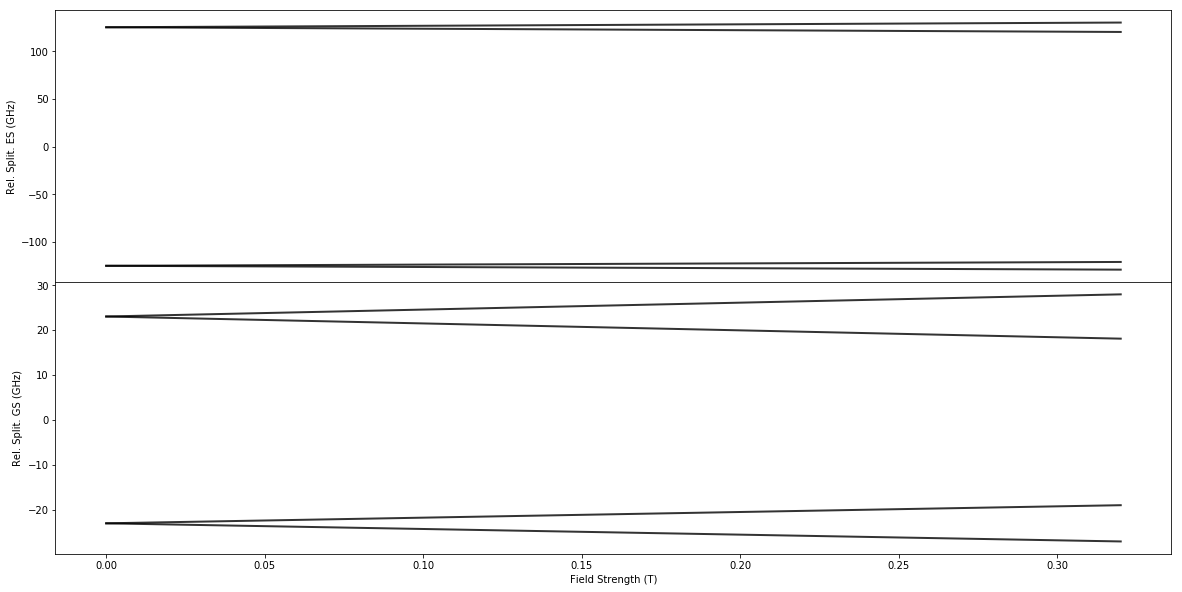

In [16]:
# Magnetic field orientation with respect to external lab frame, where z defines the optical axis
B_theta, B_phi = 54.7, 45
Bs = np.linspace(0, 0.32, 15)
engs = np.zeros( (len(Bs), sgx.shape[0]) )

# Transform Bfield vector into reference frame 
bx, by, bz = Rx(theta_x)@Rz(theta_z)@Rs(B_theta, B_phi)

for i, B in enumerate(Bs):
    Bx = B*bx
    By = B*by
    Bz = B*bz    
    
    HC = w_C/2*tensor(eux*eux.dag() + euy*euy.dag() - egx*egx.dag() - egy*egy.dag(), qeye(2))
    
    HSO = lbd_SO_g/2 * sgy * Sz + lbd_SO_u/2 * suy * Sz
    
    HZS = g_e * muB/2 * (Sx * Bx + Sy * By + Sz * Bz)
    HZL = q * muB * (sgy + suy) * Bz
    
    HStr = alpha_g*sgz + beta_g*sgx + alpha_u*suz + beta_g*sux
    
    H = HC + HSO + HZS + HZL + HStr    
    H = H.tidyup(1e-10)
    
    engs[i, :] = H.eigenstates()[0]     

    
gs = 0.5 * abs((tensor(egm.dag(), su.dag())*H*tensor(egm, su) - tensor(egp.dag(), su.dag())*H*tensor(egp, su))[0,0])
gs += 0.5 * abs((tensor(egp.dag(), sd.dag())*H*tensor(egp, sd) - tensor(egm.dag(), sd.dag())*H*tensor(egm, sd))[0,0])
print("Groundstate splitting: ", gs/(2*np.pi))
es = 0.5 * abs((tensor(eum.dag(), su.dag())*H*tensor(eum, su) - tensor(eup.dag(), su.dag())*H*tensor(eup, su))[0,0])
es += 0.5 * abs((tensor(eup.dag(), sd.dag())*H*tensor(eup, sd) - tensor(eum.dag(), sd.dag())*H*tensor(eum, sd))[0,0])
print("Excited state splitting: ", es/(2*np.pi))

print(engs[-1,:])
print("5-4 Splitting: ", (engs[-1,5] - engs[-1,4])/(2*pi))
print("3-2 Splitting: ", (engs[-1,3] - engs[-1,2])/(2*pi))
print("1-0 Splitting: ", (engs[-1,1] - engs[-1,0])/(2*pi))
print("2-0 Splitting: ", (engs[-1,2] - engs[-1,0])/(2*pi))


fig, axs = plt.subplots(2,1, figsize=(20,10), sharex=True, squeeze=True)
for j in range(int(engs.shape[1]/2)):    
    
    axs[0].plot(Bs, (engs[:,j+int(engs.shape[1]/2)]-w_C/2)*1/(2*pi), color='k', alpha=0.8, lw=2)
    axs[1].plot(Bs, (engs[:,j]+w_C/2)*1/(2*pi), color='k', alpha=0.8, lw=2)

axs[1].set_ylabel("Rel. Split. GS (GHz)")
axs[1].set_xlabel("Field Strength (T)")
axs[0].set_ylabel("Rel. Split. ES (GHz)")
plt.subplots_adjust(wspace=0, hspace=0)

In [705]:
Gamma_opt = 1e-3*1/(2*pi*1.73)
Gamma_phon_g0 = 1e-3*1/(2*pi*40)
Gamma_phon_u0 = 1e-3*1/(2*pi*0.4)
Gamma_spin = 1e-3*1/(1e3)

gs0 = lbd_SO_g
# gs = tensor(egp*egm.dag(),su*su.dag()) /(2*pi)
# es = (engs[-1,6]-engs[-1,4])/(2*pi)

Gamma_phon_g = Gamma_phon_g0*(gs/gs0)**3 * coth(gs,T) / coth(gs0,T)
Gamma_phon_g = Gamma_phon_g
print("Extrapolated T1: ", 1/(2*pi*Gamma_phon_g))

es0 = lbd_SO_u
Gamma_phon_u = Gamma_phon_u0*(es/es0)**3 * coth(es,T) / coth(es0,T)

c_ops = []

# Optical decays defined from SO basis (only Emission relevant)
c_ops.append(np.sqrt(Gamma_opt)*sigm_x)
c_ops.append(np.sqrt(Gamma_opt)*sigm_y)
c_ops.append(np.sqrt(Gamma_opt)*sigm_z)

# Phononic relaxation
# Emission
c_ops.append(np.sqrt(1/(boltzmann(gs*1e9, T)+1)*Gamma_phon_g) * (tensor(egp*egm.dag(),su*su.dag()) + tensor(egm*egp.dag(), sd*sd.dag())))
c_ops.append(np.sqrt(1/(boltzmann(es*1e9, T)+1)*Gamma_phon_u) * (tensor(eup*eum.dag(),su*su.dag()) + tensor(eum*eup.dag(), sd*sd.dag())))

# Absorption
c_ops.append(np.sqrt(boltzmann(gs*1e9, T)/(boltzmann(gs*1e9, T)+1)*Gamma_phon_g) * (tensor(egp*egm.dag(),sd*sd.dag()) + tensor(egm*egp.dag(),su*su.dag())))
c_ops.append(np.sqrt(boltzmann(es*1e9, T)/(boltzmann(es*1e9, T)+1)*Gamma_phon_u) * (tensor(eup*eum.dag(),sd*sd.dag()) + tensor(eum*eup.dag(),su*su.dag())))

#Spin relaxation
# c_ops.append(np.sqrt(Gamma_spin)*tensor(egm*egp.dag() + egp*egm.dag() + eum*eup.dag() + eup*eum.dag(), sd*su.dag()))
# c_ops.append(np.sqrt(Gamma_spin)*tensor(egp*egm.dag() + egm*egp.dag() + eum*eup.dag() + eup*eum.dag(), su*sd.dag())) 
c_ops.append(np.sqrt(Gamma_spin)*tensor(qeye(4), sd*su.dag()))
c_ops.append(np.sqrt(Gamma_spin)*tensor(qeye(4), su*sd.dag())) 

Extrapolated T1:  40000.00000000247


In [706]:
trans_engs = np.zeros(H.shape)
trans_dipoles = np.zeros(H.shape)

engs_ = H.eigenstates()[0]
evs_ = H.eigenstates()[1]

for i, engi in enumerate(engs_):
    for j, engj in enumerate(engs_[:i]):         
        if round(abs(engi-engj),3)<1e4: continue
        trans_engs[i,j] = abs(engi-engj)
        trans_dipoles[i,j] = abs((evs_[i].dag() * px * evs_[j])[0,0])**2 + abs((evs_[i].dag() * py * evs_[j])[0,0])**2 + abs((evs_[i].dag() * pz * evs_[j])[0,0])**2

# transitions = list(sorted(set(trans_engs[trans_engs.nonzero()])))
transitions = np.array(list(sorted(trans_engs[trans_engs.nonzero()])))

D = transitions[0*len(transitions)//4:1*len(transitions)//4]
C = transitions[1*len(transitions)//4:2*len(transitions)//4]
B = transitions[2*len(transitions)//4:3*len(transitions)//4]
A = transitions[3*len(transitions)//4:4*len(transitions)//4]

In [707]:
pwidth = 100
ptau = 100
pN = 10
pL = pN * pwidth + np.sum(np.arange(1,pN,1))*ptau

tlist = np.arange(0, pL, 0.05)
starts, stops, seq = pulse_seq(tlist, pwidth, tau=ptau, N=pN)

B = 0.3
B_thetas = np.linspace(-45, 45, 1)
B_phi = 45
T1 = np.zeros_like(B_thetas)
peaks = np.zeros( (len(B_thetas), pN) )
for i, B_theta in enumerate(B_thetas):
    # Transform Bfield vector into reference frame 
    bx, by, bz = Rx(theta_x)@Rz(theta_z)@Rs(B_theta, B_phi)
    Bx = B*bx
    By = B*by
    Bz = B*bz    
    
    HC = w_C/2*tensor(eux*eux.dag() + euy*euy.dag() - egx*egx.dag() - egy*egy.dag(), qeye(2))
    
    HSO = -lbd_SO_g/2 * sgy * Sz -lbd_SO_u/2 * suy * Sz
    
    HZS = g_e * muB/2 * (Sx * Bx + Sy * By + Sz * Bz)
    HZL = -0.13 * muB * (-sgy - suy) * Bz
    
    HStr = alpha_g*sgz + beta_g*sgx + alpha_u*suz + beta_g*sux
    
    H = HC + HSO + HZS + HZL + HStr    
    H = H.tidyup(1e-10)
    
    engs, evs = H.eigenstates() 

    w_L = engs[5] - engs[0]
    Omega_L = 20*Gamma_opt
    Hint = Omega_L/2 * (evs[5]*evs[0].dag() + evs[0]*evs[5].dag())

    rho0 = steadystate(H, c_ops)
    e_ops_ = [
        evs_[0]*evs_[0].dag(),
        evs_[1]*evs_[1].dag(),
        evs_[2]*evs_[2].dag(),
        evs_[3]*evs_[3].dag(),
        evs_[4]*evs_[4].dag(),
        evs_[5]*evs_[5].dag(),
        evs_[6]*evs_[6].dag(),
        evs_[7]*evs_[7].dag()
    ]
    results = mesolve([H - w_L/2 * HC/(w_C/2), [Hint,seq]], rho0, tlist, c_ops=c_ops, e_ops=e_ops, progress_bar = ui.TextProgressBar())
    exps = np.array(results.expect)
    
    pops_tot = np.sum(np.array(results.expect)[4:,:], axis=0)
    for j, (start, stop) in enumerate(zip(starts, stops)):    
        peaks[i, j] = np.sum(pops_tot[np.argwhere( (tlist >= start) & (tlist < stop)).flatten()])

    x = np.arange(1, pN) 
    print(peaks)
    y = peaks[i, 1:]/peaks[i, 0]
    fit_func= lambda tau, a, T0, T1: a*(1-np.exp(-(tau-T0)/T1))
    try:        
        popt, pcov = cf(fit_func, x, y)
        T1[i] = popt[2]*ptau
    except:
        print("Fit error")

10.0%. Run time:  14.75s. Est. time left: 00:00:02:12


KeyboardInterrupt: 

Extrapolated T1:  92.4143205557903
10.0%. Run time:   2.22s. Est. time left: 00:00:00:19
20.0%. Run time:   4.17s. Est. time left: 00:00:00:16
30.0%. Run time:   6.10s. Est. time left: 00:00:00:14
40.0%. Run time:   8.03s. Est. time left: 00:00:00:12
50.0%. Run time:  11.17s. Est. time left: 00:00:00:11
60.0%. Run time:  13.11s. Est. time left: 00:00:00:08
70.0%. Run time:  15.10s. Est. time left: 00:00:00:06
80.0%. Run time:  16.99s. Est. time left: 00:00:00:04
90.0%. Run time:  18.87s. Est. time left: 00:00:00:02
Total run time:  20.90s


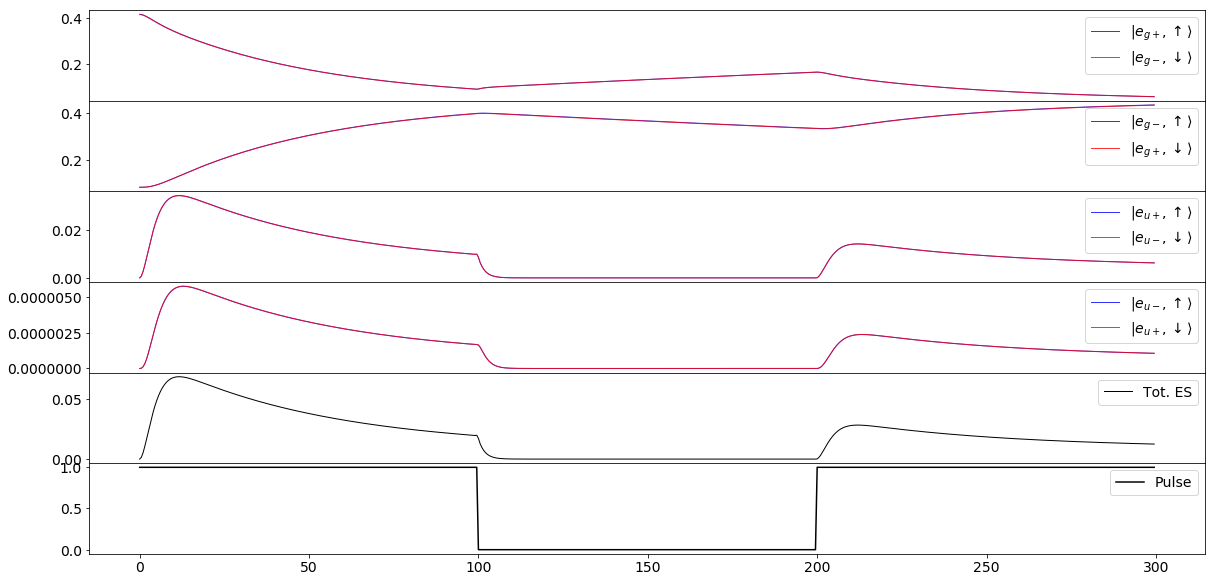

In [775]:
pwidth = 100
ptau = 100
pN = 2
pL = pN * pwidth + np.sum(np.arange(1,pN,1))*ptau

T = 2
Gamma_opt = 1/(2*pi*1.73)
Gamma_phon_g0 = 1/(2*pi*40)
Gamma_phon_u0 = 1/(2*pi*0.4)
Gamma_spin = 1/(2*pi*1e3)

gs0 = lbd_SO_g
# gs = tensor(egp*egm.dag(),su*su.dag()) /(2*pi)
# es = (engs[-1,6]-engs[-1,4])/(2*pi)

Gamma_phon_g = Gamma_phon_g0*(gs/gs0)**3 * coth(gs/(2*pi),T) / coth(gs0/(2*pi),5)
print("Extrapolated T1: ", 1/(2*pi*Gamma_phon_g))

es0 = lbd_SO_u
Gamma_phon_u = Gamma_phon_u0*(es/es0)**3 * coth(es,T) / coth(es0,T)

c_ops = []

# Optical decays defined from SO basis (only Emission relevant)
c_ops.append(np.sqrt(Gamma_opt)*sigm_x)
c_ops.append(np.sqrt(Gamma_opt)*sigm_y)
c_ops.append(np.sqrt(Gamma_opt)*sigm_z)

# Phononic relaxation
# Emission
c_ops.append(np.sqrt(1/(boltzmann(gs*1e9, T)+1)*Gamma_phon_g) * (tensor(egp*egm.dag(),su*su.dag()) + tensor(egm*egp.dag(), sd*sd.dag())))
c_ops.append(np.sqrt(1/(boltzmann(es*1e9, T)+1)*Gamma_phon_u) * (tensor(eup*eum.dag(),su*su.dag()) + tensor(eum*eup.dag(), sd*sd.dag())))

# Absorption
c_ops.append(np.sqrt(boltzmann(gs*1e9, T)/(boltzmann(gs*1e9, T)+1)*Gamma_phon_g) * (tensor(egp*egm.dag(),sd*sd.dag()) + tensor(egm*egp.dag(),su*su.dag())))
c_ops.append(np.sqrt(boltzmann(es*1e9, T)/(boltzmann(es*1e9, T)+1)*Gamma_phon_u) * (tensor(eup*eum.dag(),sd*sd.dag()) + tensor(eum*eup.dag(),su*su.dag())))

#Spin relaxation
# c_ops.append(np.sqrt(Gamma_spin)*tensor(egm*egp.dag() + egp*egm.dag() + eum*eup.dag() + eup*eum.dag(), sd*su.dag()))
# c_ops.append(np.sqrt(Gamma_spin)*tensor(egp*egm.dag() + egm*egp.dag() + eum*eup.dag() + eup*eum.dag(), su*sd.dag())) 
c_ops.append(np.sqrt(Gamma_spin)*tensor(qeye(4), sd*su.dag()))
c_ops.append(np.sqrt(Gamma_spin)*tensor(qeye(4), su*sd.dag())) 

tlist = np.arange(0, pL, 0.5)
starts, stops, seq = pulse_seq(tlist, pwidth, tau=ptau, N=pN)

bx, by, bz = Rx(theta_x)@Rz(theta_z)@Rs(54.70, 45)
B = 0.1
Bx = B*bx
By = B*by
Bz = B*bz    

HStr = 0*sgz + 0*sgx + 0*suz + 0*sux
HZS = g_e * muB/2 * (Sx * Bx + Sy * By + Sz * Bz)
HZL = -0.13 * muB * (-sgy - suy) * Bz

H = HC + HSO + HZS + HZL + HStr    
H = H.tidyup(1e-10)

engs, evs = H.eigenstates() 

w_L = engs[4] - engs[0] + (engs[1]-engs[0])/2
Hint = Gamma_opt/2 * (pz)

# Q = Eigenbasis_Expansion(H)
# H_eig = np.linalg.inv(Q)@(H - engs[4]*evs[4]*evs[4].dag() - engs[0]*evs[0]*evs[0].dag()).full()@Q
# H_eig = np.where(np.abs(H_eig)<1e2, H_eig, 0)
# H = Qobj(Q@H_eig@np.linalg.inv(Q), dims=H.dims).tidyup(1e-9)

results = mesolve([(H - (engs[4] - engs[0])/w_C*HC), [Hint,seq]], 
                  rho0, tlist, 
                  c_ops=c_ops, e_ops=e_ops, 
                  options = Options(nsteps=5000),
                  progress_bar = ui.TextProgressBar())
exps = np.array(results.expect)

pops_tot = np.sum(np.array(results.expect)[4:,:], axis=0)
                  
fig, axs = plt.subplots(6,1, sharex=True, figsize = (20,10))

axs[0].plot(tlist, exps[0, :], label=r'$\|e_{g+}, \uparrow\rangle$', color='b', alpha=.8, lw=1)
axs[0].plot(tlist, exps[1, :], label=r'$\|e_{g-}, \downarrow\rangle$', color='r', alpha=.8, lw=1)
axs[0].legend()

axs[1].plot(tlist, exps[2, :], label=r'$\|e_{g-}, \uparrow\rangle$', color='b', alpha=.8, lw=1)
axs[1].plot(tlist, exps[3, :], label=r'$\|e_{g+}, \downarrow\rangle$', color='r', alpha=.8, lw=1)
axs[1].legend()

axs[2].plot(tlist, exps[4, :], label=r'$\|e_{u+}, \uparrow\rangle$', color='b', alpha=.8, lw=1)
axs[2].plot(tlist, exps[5, :], label=r'$\|e_{u-}, \downarrow\rangle$', color='r', alpha=.8, lw=1)
axs[2].legend()

axs[3].plot(tlist, exps[6, :], label=r'$\|e_{u-}, \uparrow\rangle$', color='b', alpha=.8, lw=1)
axs[3].plot(tlist, exps[7, :], label=r'$\|e_{u+}, \downarrow\rangle$', color='r', alpha=.8, lw=1)
axs[3].legend()

axs[4].plot(tlist, pops_tot, label='Tot. ES', color='k', lw=1)
axs[4].legend()

axs[5].plot(tlist, seq, label='Pulse', color='k', alpha=1)
axs[5].legend()
plt.subplots_adjust(wspace=0, hspace=0)

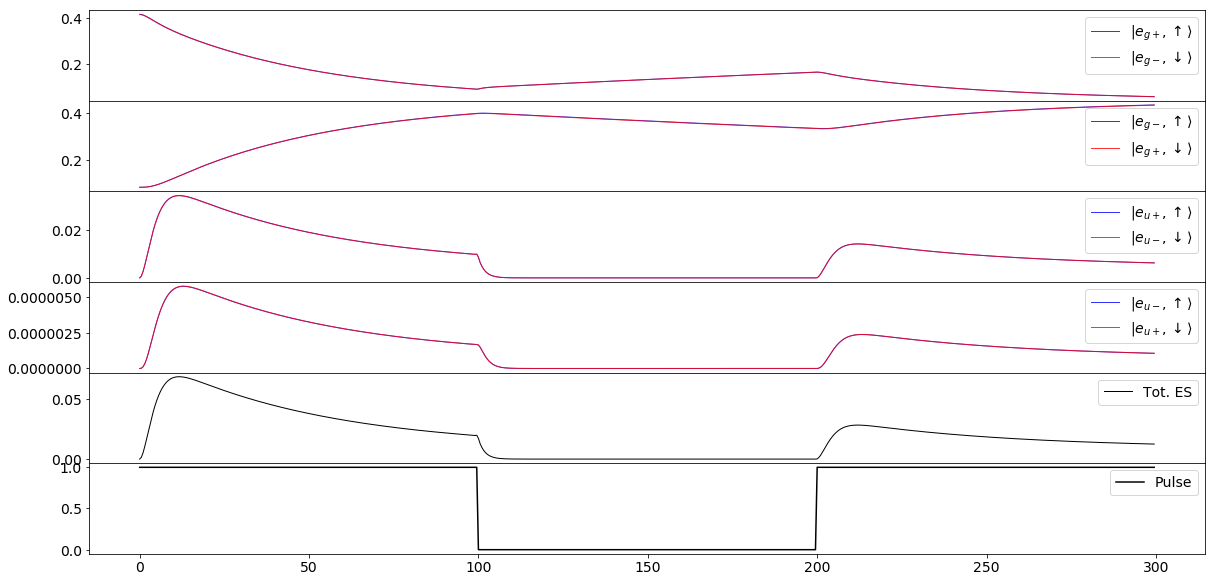

In [777]:
pops_tot = np.sum(np.array(results.expect)[4:,:], axis=0)
                  
fig, axs = plt.subplots(6,1, sharex=True, figsize = (20,10))

axs[0].plot(tlist, exps[0, :], label=r'$\|e_{g+}, \uparrow\rangle$', color='b', alpha=.8, lw=1)
axs[0].plot(tlist, exps[1, :], label=r'$\|e_{g-}, \downarrow\rangle$', color='r', alpha=.8, lw=1)
axs[0].legend()

axs[1].plot(tlist, exps[2, :], label=r'$\|e_{g-}, \uparrow\rangle$', color='b', alpha=.8, lw=1)
axs[1].plot(tlist, exps[3, :], label=r'$\|e_{g+}, \downarrow\rangle$', color='r', alpha=.8, lw=1)
axs[1].legend()

axs[2].plot(tlist, exps[4, :], label=r'$\|e_{u+}, \uparrow\rangle$', color='b', alpha=.8, lw=1)
axs[2].plot(tlist, exps[5, :], label=r'$\|e_{u-}, \downarrow\rangle$', color='r', alpha=.8, lw=1)
axs[2].legend()

axs[3].plot(tlist, exps[6, :], label=r'$\|e_{u-}, \uparrow\rangle$', color='b', alpha=.8, lw=1)
axs[3].plot(tlist, exps[7, :], label=r'$\|e_{u+}, \downarrow\rangle$', color='r', alpha=.8, lw=1)
axs[3].legend()

axs[4].plot(tlist, pops_tot, label='Tot. ES', color='k', lw=1)
axs[4].legend()

axs[5].plot(tlist, seq, label='Pulse', color='k', alpha=1)
axs[5].legend()
plt.subplots_adjust(wspace=0, hspace=0)

In [8]:
pL = pN * pwidth + np.sum(np.arange(1,pN,1))*ptau
peaks = np.zeros(pN)
for i, (start, stop) in enumerate(zip(starts, stops)):    
    peaks[i] = np.sum(pops_tot[np.argwhere( (tlist >= start) & (tlist < stop)).flatten()])

x = np.arange(1, pN) 
y = peaks[1:]/peaks[0]
fit_func= lambda tau, a, T0, T1: a*(1-np.exp(-(tau-T0)/T1))
popt, pcov = cf(fit_func, x, y)
plt.plot(x, y)
plt.plot(x, fit_func(x, *popt))
print(popt[2]*ptau)

NameError: name 'pN' is not defined

In [9]:
Omega_L = 5*Gamma_opt
eps_x, eps_y, eps_z = Rx(theta_x)@Rz(theta_z)@Rs(54.7+90,45)

# w_Ls = np.linspace(-50+min(transitions), max(transitions)+50, 2000)
w_Ls = np.linspace(-5+D[0], D[3]+5, 200)
pops = np.zeros((len(w_Ls), 4)) 
I = np.zeros((len(w_Ls), 3))
for i, w_L in enumerate(w_Ls):    
    
    Hint = Omega_L/2*(eps_x*px + eps_y*py + eps_z*pz) - (w_L + 0*D[1])/2 * HC/(w_C/2)
    Hint = Hint.tidyup()
    
    rho_ss = steadystate(H+Hint, c_ops)
        
    pops[i,0] = np.real(rho_ss[4,4])
    pops[i,1] = np.real(rho_ss[5,5])
    pops[i,2] = np.real(rho_ss[6,6])
    pops[i,3] = np.real(rho_ss[7,7])
    
    I[i,0] = abs((rho_ss*px).tr())**2
    I[i,1] = abs((rho_ss*(-1j)*py).tr())**2
    I[i,2] = abs((rho_ss*pz).tr())**2

NameError: name 'Gamma_opt' is not defined

0.09199707693173141 1.51449854265034 0.105087551166195


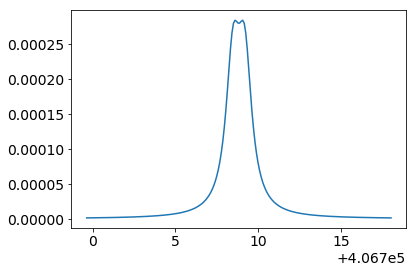

In [784]:
pops_tot = np.sum(pops,axis=1)
pops_tot = pops_tot

plt.plot(w_Ls/(2*pi), pops_tot)

p0 = (w_Ls[np.argmax(pops_tot)]/(2*pi), Gamma_opt, np.amax(pops_tot), 0)
fit_func = lorentzian
popt, pcov = cf(fit_func, w_Ls/(2*pi), pops_tot, p0=p0)
# plt.plot(w_Ls/(2*pi), fit_func(w_Ls/(2*pi), *popt), '-r')
print(Gamma_opt, popt[1], 1/(2*pi*popt[1]))

In [13]:
B_thetas = np.linspace(54.7-1, 54.7+1, 10)

dipxy = 1/np.sqrt(2)*(px+1j*py)
dipz = pz/2
d_C = np.zeros( (len(B_thetas), 4, 3) )
d_D = np.zeros( (len(B_thetas), 4, 3) )

for i, B_theta in enumerate(B_thetas):
    B_phi = 0
    B = 0.2
    
    # Transform Bfield vector into reference framge 
    bx, by, bz = Rx(theta_x)@Rz(theta_z)@Rs(B_theta, B_phi)
    Bx = B*bx
    By = B*by
    Bz = B*bz    
    
    HC = w_C/2*tensor(eux*eux.dag() + euy*euy.dag() - egx*egx.dag() - egy*egy.dag(), qeye(2))
    HSO = -lbd_SO_g/2 * sgy * Sz -lbd_SO_u/2 * suy * Sz
    HZS = g_e * muB/2 * (Sx * Bx + Sy * By + Sz * Bz)
    HZL = q * muB/2 * (-sgy - suy) * Bz
    HStr = (alpha_g*sgz + beta_g*sgx + alpha_u*suz + beta_g*sux)
    H = HC + HSO + HZS + HZL + HStr
    H = H.tidyup(1e-10)
    evs = H.eigenstates()[1]
    # evs[0].dag()*tensor(egm*egp.dag(), sd*sd.dag())*evs[4]
    
    # xy and z dipoles for transition C1-C4
    d_C[i, 0, 0] = abs((evs[1].dag()*dipxy*evs[4])[0][0][0])**2
    d_C[i, 1, 0] = abs((evs[0].dag()*dipxy*evs[4])[0][0][0])**2
    d_C[i, 2, 0] = abs((evs[1].dag()*dipxy*evs[5])[0][0][0])**2
    d_C[i, 3, 0] = abs((evs[0].dag()*dipxy*evs[5])[0][0][0])**2
    d_C[i, 0, 1] = abs((evs[1].dag()*dipz*evs[4])[0][0][0])**2
    d_C[i, 1, 1] = abs((evs[0].dag()*dipz*evs[4])[0][0][0])**2
    d_C[i, 2, 1] = abs((evs[1].dag()*dipz*evs[5])[0][0][0])**2
    d_C[i, 3, 1] = abs((evs[0].dag()*dipz*evs[5])[0][0][0])**2 
    d_C[i, 0, 2] = d_C[i, 0, 0] + d_C[i, 0, 1]
    d_C[i, 1, 2] = d_C[i, 1, 0] + d_C[i, 1, 1]
    d_C[i, 2, 2] = d_C[i, 2, 0] + d_C[i, 2, 1]
    d_C[i, 3, 2] = d_C[i, 3, 0] + d_C[i, 3, 1]
    
    # xy and z dipoles for transition D1-D4
    d_D[i, 0, 0] = abs((evs[3].dag()*dipxy*evs[4])[0][0][0])**2
    d_D[i, 1, 0] = abs((evs[2].dag()*dipxy*evs[4])[0][0][0])**2
    d_D[i, 2, 0] = abs((evs[3].dag()*dipxy*evs[5])[0][0][0])**2
    d_D[i, 3, 0] = abs((evs[2].dag()*dipxy*evs[5])[0][0][0])**2
    d_D[i, 0, 1] = abs((evs[3].dag()*dipz*evs[4])[0][0][0])**2
    d_D[i, 1, 1] = abs((evs[2].dag()*dipz*evs[4])[0][0][0])**2
    d_D[i, 2, 1] = abs((evs[3].dag()*dipz*evs[5])[0][0][0])**2
    d_D[i, 3, 1] = abs((evs[2].dag()*dipz*evs[5])[0][0][0])**2 
    d_D[i, 0, 2] = d_D[i, 0, 0] + d_D[i, 0, 1]
    d_D[i, 1, 2] = d_D[i, 1, 0] + d_D[i, 1, 1]
    d_D[i, 2, 2] = d_D[i, 2, 0] + d_D[i, 2, 1]
    d_D[i, 3, 2] = d_D[i, 3, 0] + d_D[i, 3, 1]

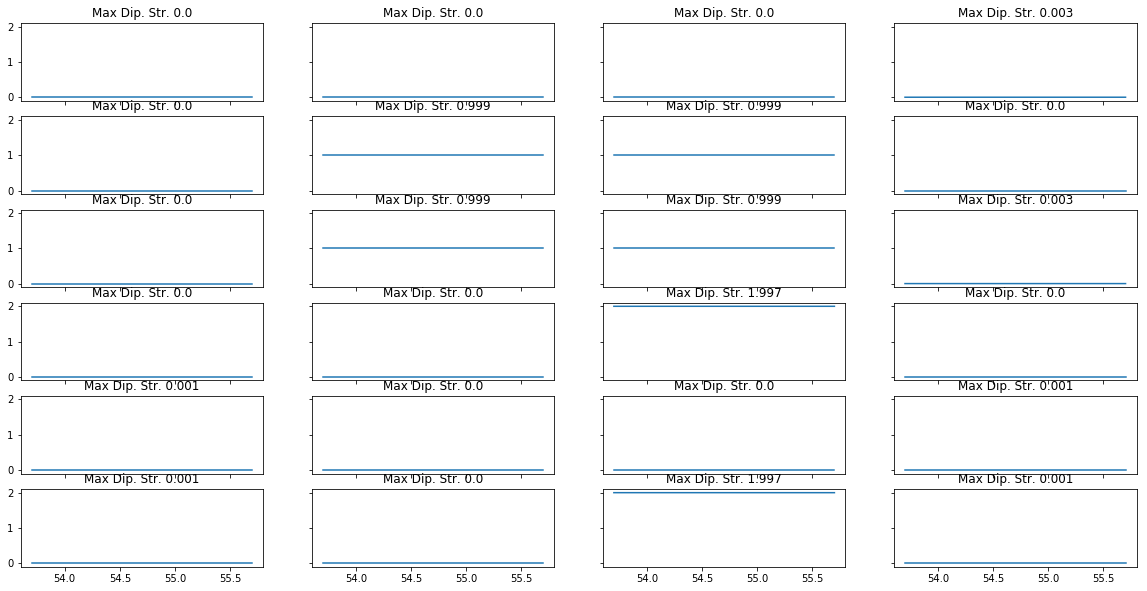

In [164]:
fig, axs = plt.subplots(6,4, sharex=True, sharey=True, figsize=(20,10))

for i in range(3):
    for j in range(4):
        axs[i,j].plot(B_thetas, d_C[:, j, i], label='C'+str(j))
        axs[i,j].set_title("Max Dip. Str. "+str(round(max(d_C[:, j, i]),3)))
        
for i in range(3):
    for j in range(4):
        axs[3+i,j].plot(B_thetas, d_D[:, j, i], label='D'+str(j))
        axs[3+i,j].set_title("Max Dip. Str. "+str(round(max(d_D[:, j, i]),3)))

[1.81123495 0.99698672]


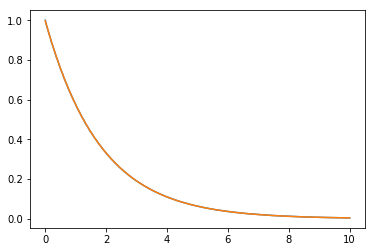

In [420]:
rho0 = evs_[4]*evs_[4].dag()
tlist = np.linspace(0,10,300)
fit_func = lambda t, tau, a: a*np.exp(-t/tau)
exp_ = mesolve(H, rho0, tlist, c_ops, rho0).expect[0]
plt.plot(tlist, exp_)
popt, pcov = cf(fit_func, tlist, exp_)
print(popt)
plt.plot(tlist, fit_func(tlist, *popt))

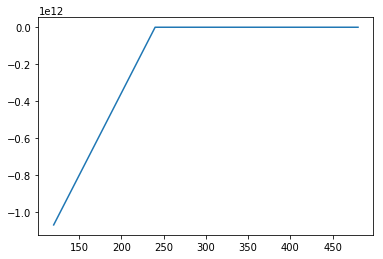

In [449]:
plt.plot(x, fit_func(x, 0.1, 150, 1))